# Community Water System Prediction Model

The [Division of Drinking Water](https://www.waterboards.ca.gov/drinking_water/programs/) (DDW) at the [California State Water Resources Control Board](https://www.waterboards.ca.gov/) regulates 2800 Community Water Systems (CWS) throughout the state. Some of these CWS risk running out of water during the dry summer season. This code creates a machine learning model that predicts which CWS face the highest risk of running out of water. The model is intended to run in production on a monthly basis, producing predictions for at-risk CWS within the subsequent ninety days. 

In [1]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Read in the data

The initial data set provided by the DDW include two csv files that contain data from 2020 and 2021. The files provide a list of CWS, various parameters that describe the CWS, and the outcome of each CWS at the end of 2021 via the label `DroughtExperienced`. If `DroughtExperienced` equals 1, a CWS ran out of water; otherwise, the system was safe.

In [2]:
BUCKET_NAME = 'aae-water-dev-us-west-2'

In [3]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
water_bucket = s3.Bucket(BUCKET_NAME)

In [4]:
files = []
for water_bucket_object in water_bucket.objects.all():
    files.append(water_bucket_object.key)

In [5]:
dfs = []
for file in files:
    response = s3_client.get_object(Bucket=BUCKET_NAME, Key=file)
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    print(status)
    if status == 200:
        dfs.append(pd.read_csv(response.get("Body")))

200
200


### Clean the data

In [6]:
df1 = dfs[0]
df2 = dfs[1]

The keyword `PWPhysicalAddressLat` in one dataframe is the same as `Lat` in other other; same with longitude. Rename these keywords.

In [7]:
df2 = df2.rename(columns={"Lat": "PWPhysicalAddressLat", "Long": "PWPhysicalAddressLong"})

Why are there multiple CWS at the same location? Is this correct? (See table below)

In [8]:
df2[['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']][30:39]

,ServiceConnections,Population,CDAG_rank,PWPhysicalAddressLat,PWPhysicalAddressLong
30,1742,4943,-1,38.382864,-120.787745
31,520,1060,2322,38.480957,-120.847427
32,388,907,1805,38.413058,-120.658861
33,215,510,1757,38.544707,-120.741079
34,211,1184,1445,38.191586,-120.829103
35,337,838,1636,38.458547,-120.541518
36,2743,8809,-1,38.382864,-120.787745
37,82,200,1713,38.447565,-120.537917
38,55,188,-1,38.382864,-120.787745


What does a CDAG_rank of -1 mean? Is this the same as NaN? There are 666 CWS with a CDAG_rank of -1.

In [9]:
df1[['ServiceConnections', 'Population', 'CWSID', 'CDAG_rank', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']].loc[df1['CDAG_rank'] == -1] 

,ServiceConnections,Population,CWSID,CDAG_rank,PWPhysicalAddressLat,PWPhysicalAddressLong
3,86788,351000,CA0110001,-1,37.505646,-121.960909
4,18491,59000,CA0110003,-1,37.679522,-121.773660
5,390779,1405000,CA0110005,-1,37.801316,-122.270839
6,34756,151600,CA0110006,-1,37.670978,-122.085697
7,22387,79201,CA0110008,-1,37.676404,-121.859063
...,...,...,...,...,...,...
2858,2669,8807,CA5805001,-1,39.095448,-121.552186
2859,3722,12231,CA5810001,-1,39.136870,-121.588352
2860,5051,19986,CA5810002,-1,39.121947,-121.567975
2861,4765,15579,CA5810003,-1,39.091222,-121.543914


Merge the two dataframes using these keys: `ServiceConnections`, `Population`, `CDAG_rank`, and `Lat`. The ideal solution is to merge on the unique identifier, `CWSID`. However, `CWSID` is not present in both files.

In [10]:
df = df1.merge(df2, on=['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat'])

Select the keywords used in the initial model.

In [11]:
df = df[['DroughtExperienced_x', 'ServiceConnections', 'Population','Score_SourceNumber_x', 'Score_SCV', 'Score_SCM_x', 
    'Score_CriticallyOverdraftedGroundwaterBasin_x', 'CDAG_rank', 'Curtailment_x',
    'Score_1702_x', 'Score_1705_x', 'Score_1706_x', 'Score_1812_x', 'Score_1813_x', 'Score_1814_x', 
    'Score_1815_x', 'EAR2020DroughtRiskScore_y', 'SAFER_AccessibilityScore_y',
    'PWPhysicalAddressLat', 'PWPhysicalAddressLong_x', 'CurtailedWatershed_x',
    'ActiveGWSource_y', 'ActiveSWSource_y', 'HUC4_x', 'FracturedRock_x',
    'Intertie_x', 'CentralValleyCounties', 'HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other',
    'DSCI2WYAvg', 'TNCFlow2WYAvg']]

Rename columns so they make more sense.

In [12]:
df.columns = df.columns.str.removesuffix("_x")
df.columns = df.columns.str.removesuffix("_y")

Redefine the following keys: 
* `CentralValleyCounties`: No is set to zero and everything else is set to 1.
* `FracturedRock`: Set string '0-000' to 0 and set 'FR-999' to 1.
* `CurtailedWatershed`: Set string 'NotInCurtailedWatershed' to 0 and everything else to 1.

Create the following new keys:
* `HUC_Categories`: The keys `HUC8_CentralValley`, `HUC8_Coast`, and `HUC8_Other` contain values that include 8-digit HUC codes or strings. The string values are identical to the keyword names (i.e. 'HUC8_CentralValley', 'HUC8_Coast', and 'HUC8_Other'). Set these string values to 1, 2, and 3, respectively, and gather these into a separate keywords called 'HUC8_Categories'.

Skip the following keys:
* `Basin_Number_part1`, `Basin12`, `Basin34`, `Basin5`, `Basin6`, `Basin789`: Ignore these variables for now to avoid introducing noise into the data set (by one-hot-encoding six variables, all of which have many possible values).

In [13]:
# Redefine CentralValleyCounties
region_dictionary = {'No':0, 'BUTTE':1, 'COLUSA':1, 'FRESNO':1, 'GLENN':1, 'KERN':1, 'KINGS':1,
       'MADERA':1, 'MERCED':1, 'PLACER':1, 'SACRAMENTO':1, 'SAN JOAQUIN':1,
       'SHASTA':1, 'SOLANO':1, 'STANISLAUS':1, 'SUTTER':1, 'TEHAMA':1, 'TULARE':1,
       'YOLO':1, 'YUBA':1}
df['CentralValleyCounties'] = df['CentralValleyCounties'].apply(lambda x: region_dictionary[x])

In [14]:
# Redefine FracturedRock
fracturedrock_dictionary = {'0-000':0, 'FR-999':1}
df['FracturedRock'] = df['FracturedRock'].apply(lambda x: fracturedrock_dictionary[x])

In [15]:
# Redefine CurtailedWatershed
watershed_dictionary = {'NotInCurtailedWatershed':0, 'PartialSacSJ':1, 'PartialSJ':1,
       'SanJoaquinRiver':1, 'SacramentoRiver':1, 'SacSJ':1, 'RussianRiver':1,
       'PartialRus':1, 'PartialSac':1, 'ScottRiver':1, 'ShastaRiver':1,
       'PartialShasta':1}
df['CurtailedWatershed'] = df['CurtailedWatershed'].apply(lambda x: watershed_dictionary[x])

In [16]:
# Create HUC_Categories

df['HUC8_CentralValley'] = df['HUC8_CentralValley'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Coast'] = df['HUC8_Coast'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Other'] = df['HUC8_Other'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Other'] = df['HUC8_Other'].replace(to_replace='160*', value=0, regex=True)

df = df.replace(to_replace='HUC8_Coast', value=1)
df = df.replace(to_replace='HUC8_CentralValley', value=2)
df = df.replace(to_replace='HUC8_Other', value=3)

df['HUC_Categories'] = np.nan

df['HUC_Categories'] = df[['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other']].max(axis=1, numeric_only=True)

df = df.drop(columns=['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other'])

### Exploratory Data Analysis

* Plot the univariate Fisher score
* Make a catplot of the curtailment versus population
* Make a catplot curtailment versus service connections
* Make a kernel density estimate pairplot for some risk scores 

[Text(0.5, 0, 'Normalized Fisher Score')]

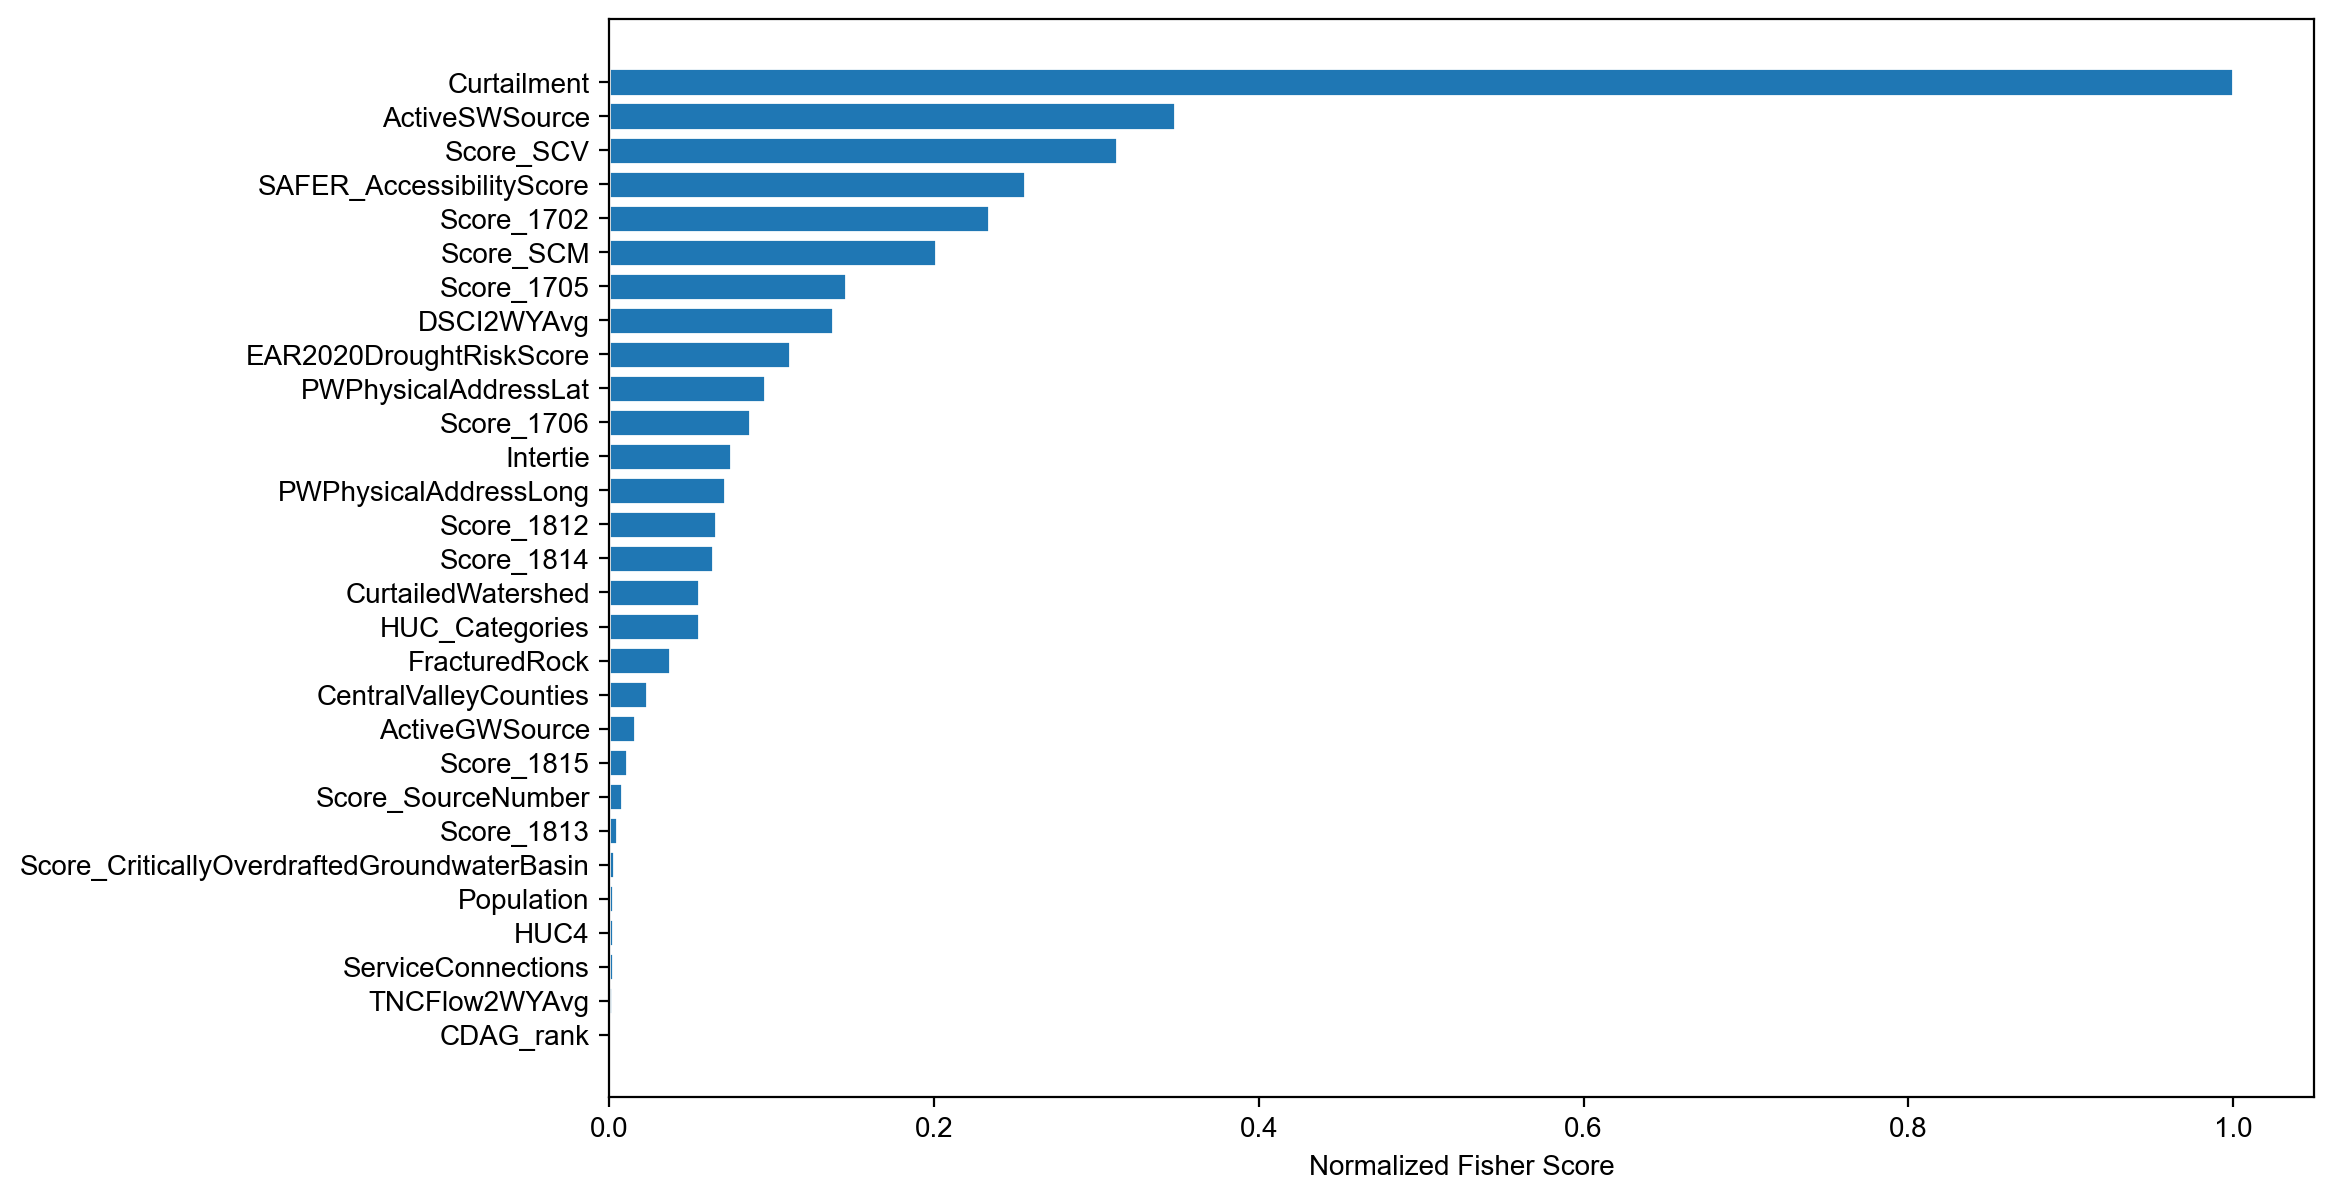

In [17]:
fig, ax = plt.subplots(figsize=(11,7))
sns.set_theme(style='whitegrid')

selector=SelectKBest(f_classif)
collist = df.columns.tolist()
selector.fit(df[collist[1:]],df['DroughtExperienced'])
scores = selector.scores_
scores[np.isnan(scores)] = 0.0

features = df[collist[1:]].columns.to_list()
order = np.argsort(scores)
ordered_features = [features[i] for i in order]
number_of_y_positions = np.arange(len(features))

ax.barh(number_of_y_positions, sorted(scores/np.nanmax(scores)))
ax.set_yticks(number_of_y_positions, ordered_features)
ax.set(xlabel = 'Normalized Fisher Score')
#fig.savefig('features.png', dpi=300, transparent=True, bbox_inches='tight')

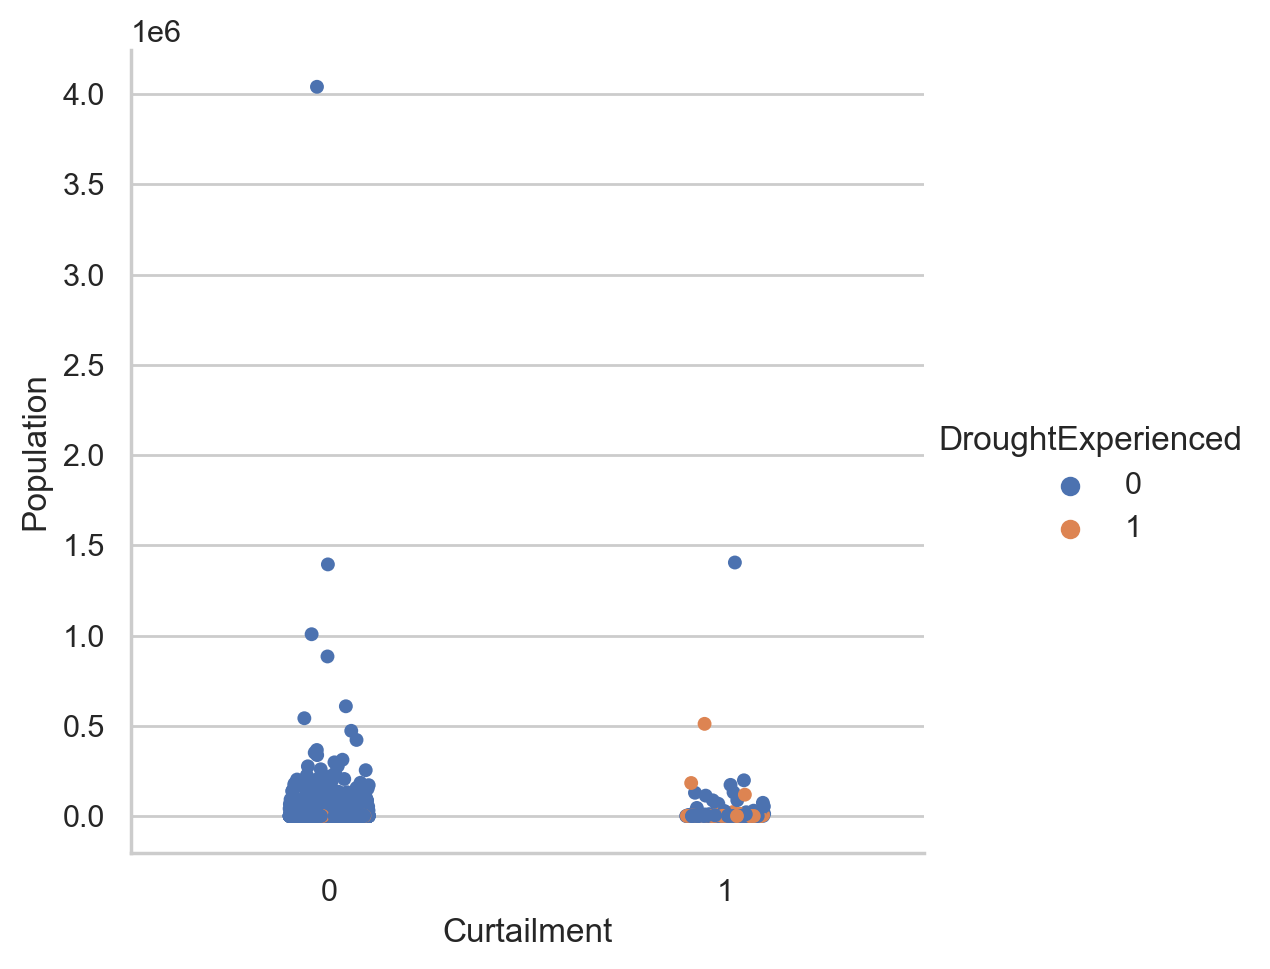

In [18]:
sns.set_theme(style='whitegrid')
fig = sns.catplot(data=df, x="Curtailment", y="Population", hue="DroughtExperienced")
#fig.savefig('curtailmentvpopulation.png', dpi=300, transparent=True, bbox_inches='tight')

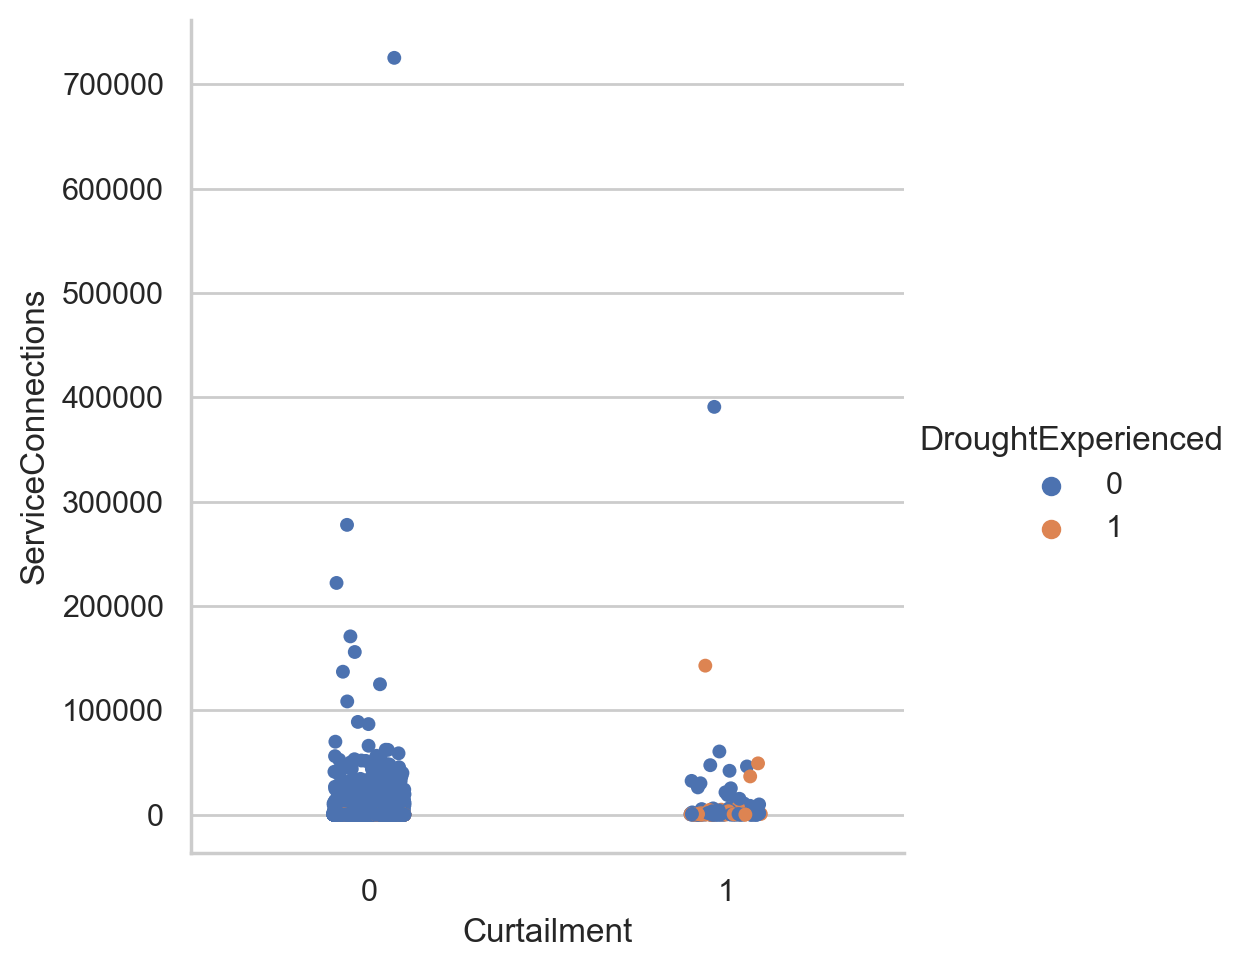

In [19]:
fig = sns.catplot(data=df, x="Curtailment", y="ServiceConnections", hue="DroughtExperienced")
#fig.savefig('curtailmentvserviceconnections.png', dpi=300, transparent=True, bbox_inches='tight')

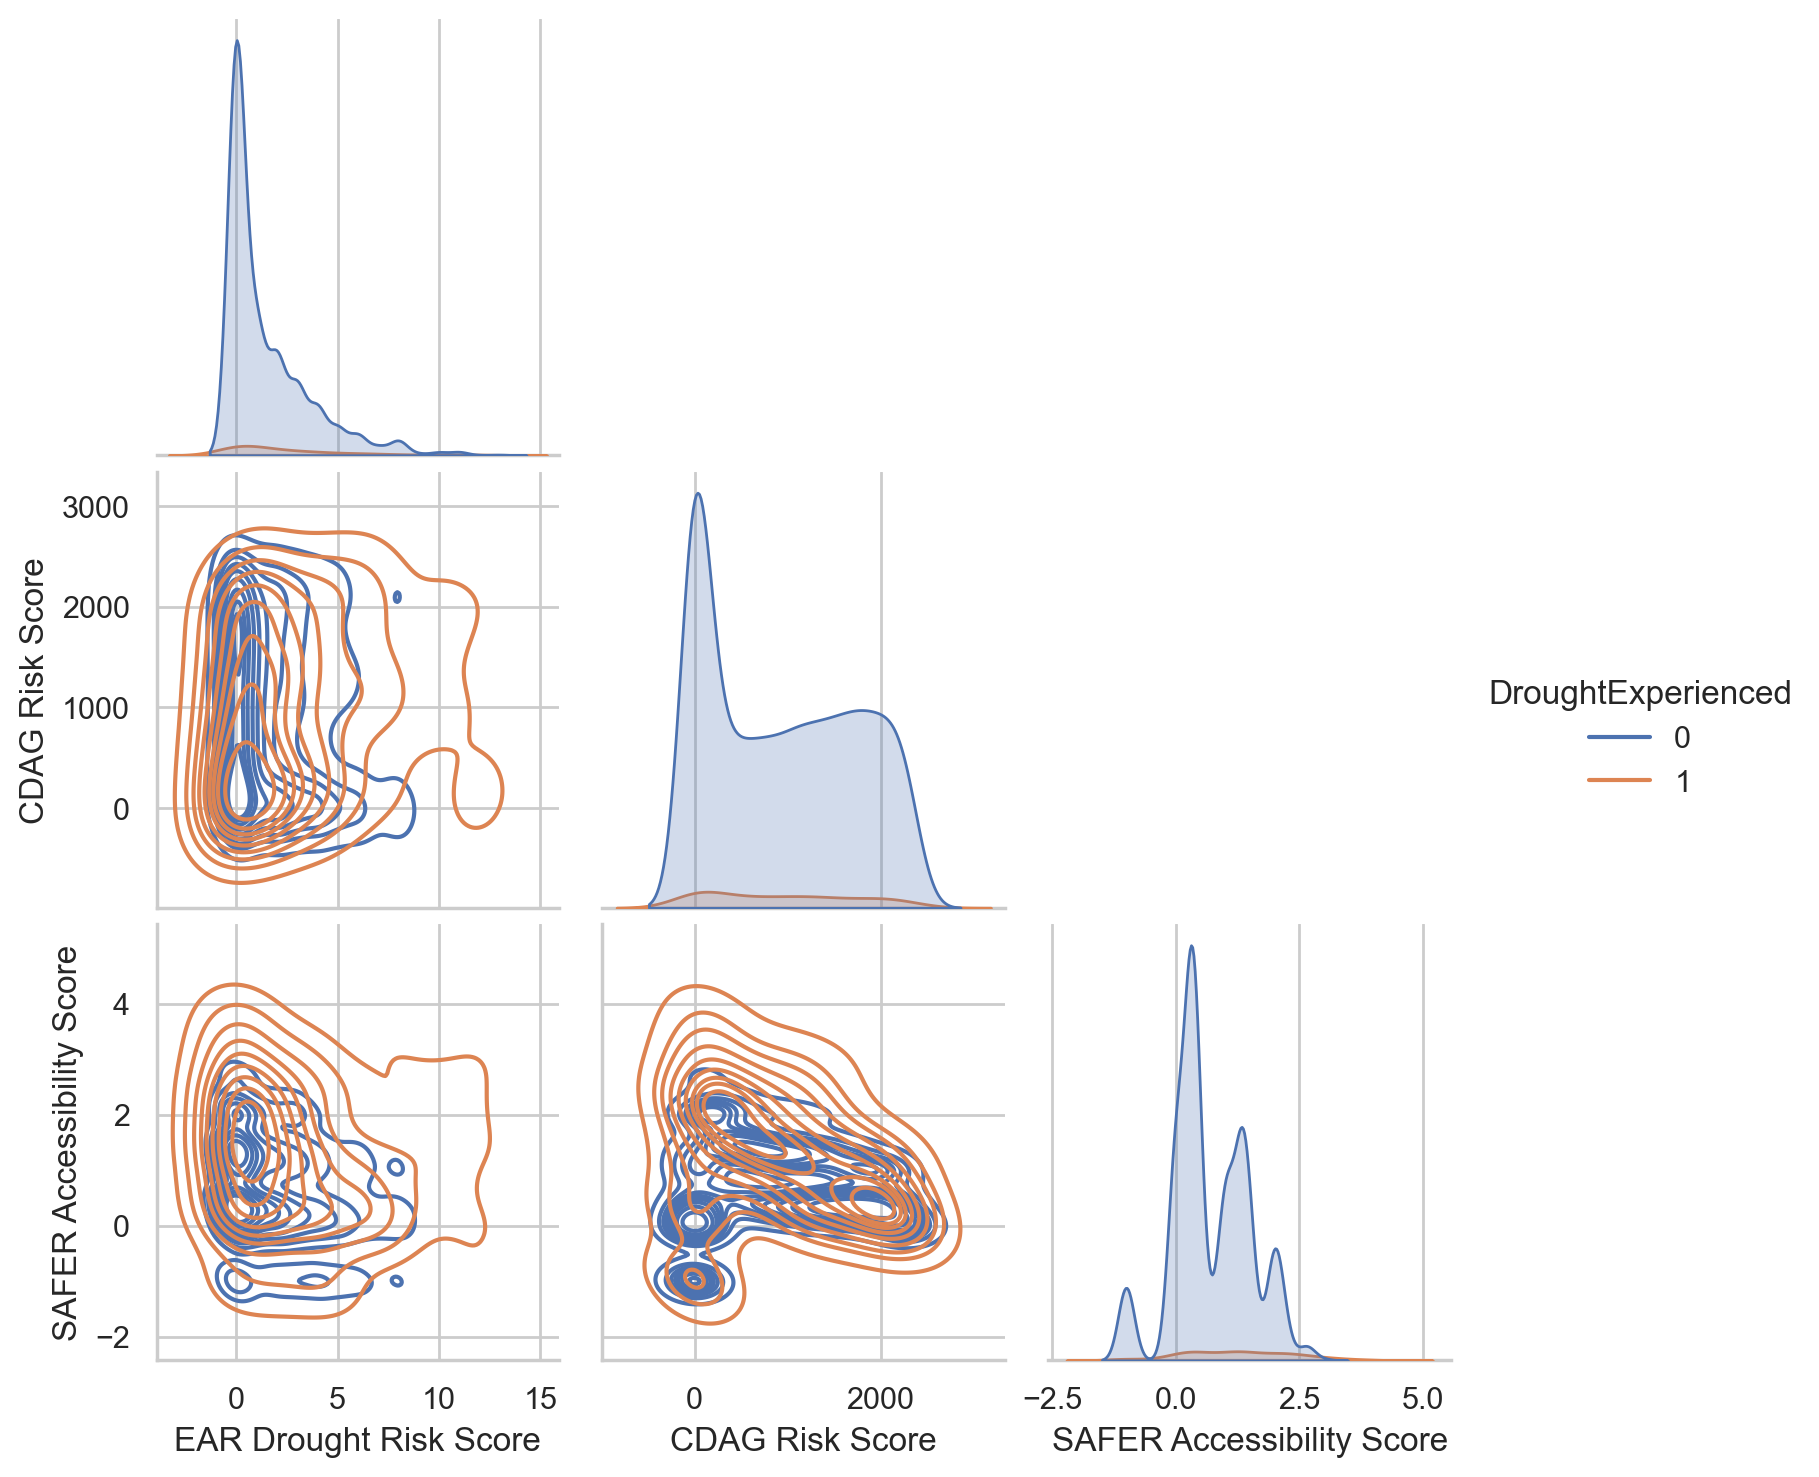

In [20]:
testdf = df[['DroughtExperienced', 'EAR2020DroughtRiskScore', 'CDAG_rank', 'SAFER_AccessibilityScore']]
testdf = testdf.rename(columns={'EAR2020DroughtRiskScore':'EAR Drought Risk Score', 'CDAG_rank': 'CDAG Risk Score', 'SAFER_AccessibilityScore': 'SAFER Accessibility Score'})
sns.pairplot(testdf, kind='kde', hue='DroughtExperienced', corner=True, plot_kws=dict(common_norm=False))#.savefig('kde.png', dpi=300, transparent=True, bbox_inches='tight')

### Split the data

Split the data into a training and a validation set.

In [21]:
y = df['DroughtExperienced']

In [22]:
X = df.drop(columns = 'DroughtExperienced')

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7, shuffle=True)

In [24]:
print(f"The training set is {len(X_train)/len(X)*100}% of the data.")
print(f"The validation set is {len(X_val)/len(X)*100}% of the data.")

The training set is 69.9930216329379% of the data.
The validation set is 30.00697836706211% of the data.


### Scale the data

Scale the numeric features assuming the data obey a Gaussian distribution (is this is a reasonably fair assumption?). Leave the categorical features unscaled.

In [25]:
numeric_features = ['ServiceConnections', 'Population', 'CDAG_rank',
                    'SAFER_AccessibilityScore', 'PWPhysicalAddressLat',
                    'PWPhysicalAddressLong','ActiveGWSource', 'ActiveSWSource',
                    'DSCI2WYAvg', 'TNCFlow2WYAvg']
                    
categorical_features = ['Score_SourceNumber', 'Score_SCV',
       'Score_SCM', 'Score_CriticallyOverdraftedGroundwaterBasin', 
       'Curtailment', 'Score_1702', 'Score_1705', 'Score_1706', 'Score_1812',
       'Score_1813', 'Score_1814', 'Score_1815', 'EAR2020DroughtRiskScore',
       'CurtailedWatershed', 'HUC4', 'FracturedRock', 'Intertie',
       'CentralValleyCounties', 'HUC_Categories']

In [26]:
if (len(numeric_features) + len(categorical_features)) == len(X.columns):
    print('All variables are included.')

All variables are included.


Select and scale the numeric features.

In [27]:
X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

In [28]:
scaler = preprocessing.StandardScaler()

Scale the validation set using the same mean and variance as the training set.

In [29]:
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

Append the unscaled categorical features.

In [30]:
X_train_categorical = np.array(X_train[categorical_features])
X_val_categorical = np.array(X_val[categorical_features])

In [31]:
X_train = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
X_val = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)

In [32]:
X_train.shape, X_val.shape

((2006, 29), (860, 29))

### Train the model

* Using a RandomForestClassifier and same parameter values for now to mimic the original DDW model

In [33]:
clf = RandomForestClassifier(max_features=29, n_estimators=770, n_jobs=-1, random_state=42)

In [34]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=29, n_estimators=770, n_jobs=-1,
                       random_state=42)

In [35]:
y_pred = clf.predict(X_val)

### Are the most predictive features static over time? Yes.

[Text(0.5, 0, 'Gini Importance')]

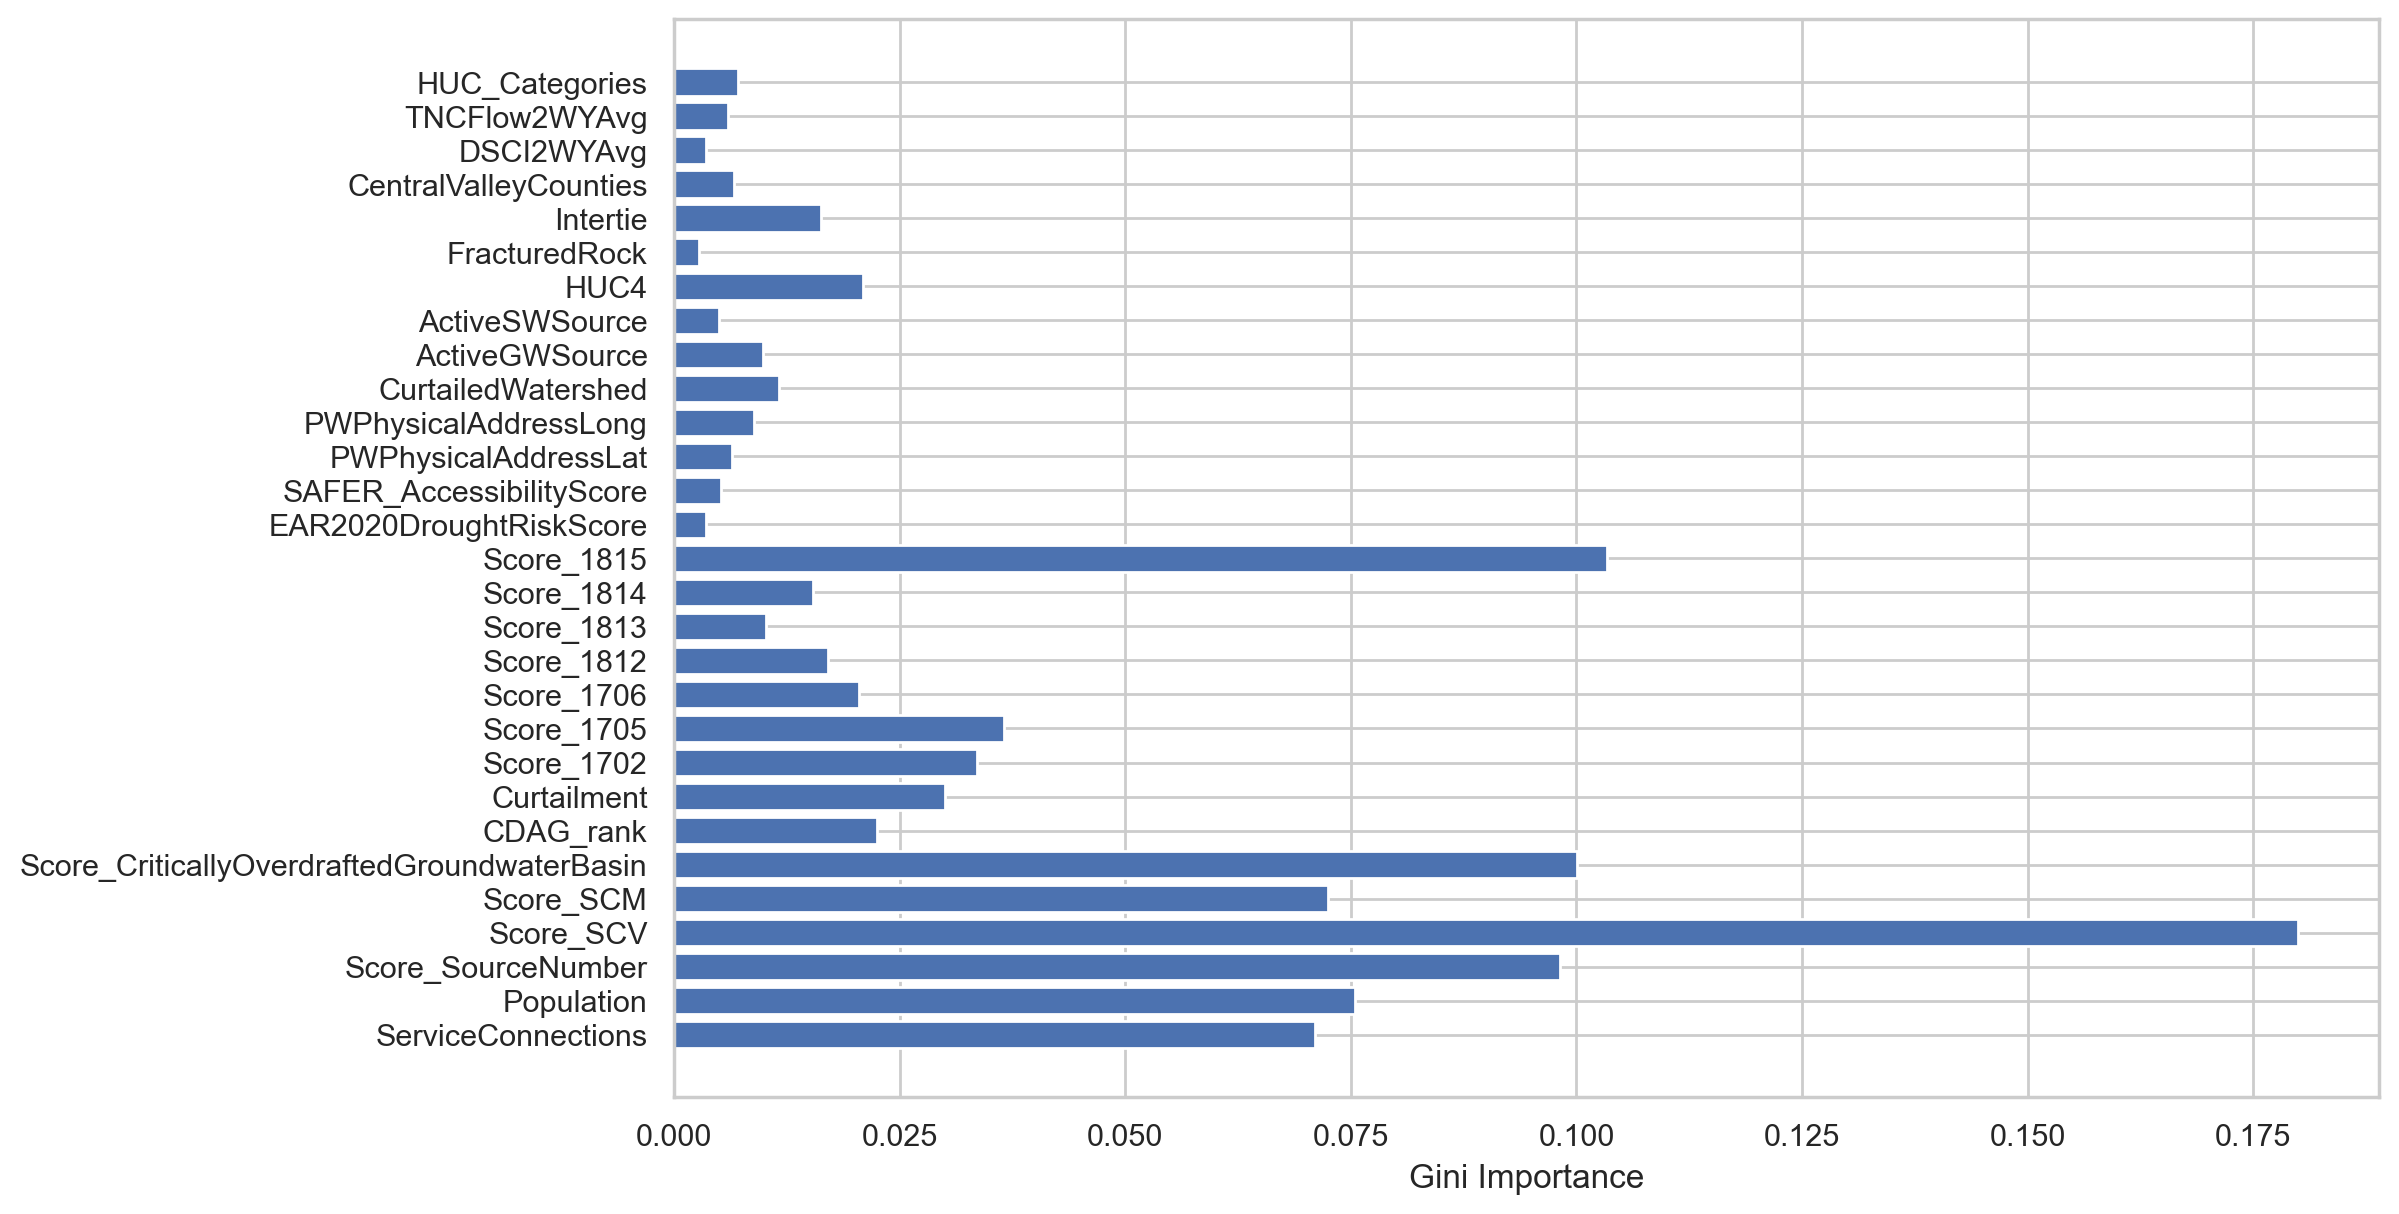

In [36]:
fig, ax = plt.subplots(figsize=(11,7))
sns.set_theme(style='whitegrid')

features = X.columns.tolist()
scores = clf.feature_importances_

ax.barh(features, scores)
ax.set(xlabel = 'Gini Importance')
#fig.savefig('Gini.png', dpi=300, transparent=True, bbox_inches='tight')

The most predictive features are:
* `Score_SCV`: If CWS had a source capacity violation in the past three years. [**Static**]
* `Score_1815`: Whether the region relies on imported water (0, 1, and 2 means low, medium, and high). [**Static**]
* `Score_CriticallyOverdraftedGroundwaterBasin`: If CWS is located in critically overdrafted groundwater basin. [**Static**]
* `Score_SourceNumber`: Number of sources (a value of 1 means there is one source, a value of 0.5 means that there are two sources, and a value is 0 represents all other situations) [**Static**]
* `Population`: The population that the community water system serves. [**Static**]
* `Score_SCM`: If CWS had a service connection moratorium in the past three years. [**Static**]
* `ServiceConnections`: The number of service connections out of the community water system. [**Static**]

These two numerical features describe drought and flow characteristics:
* `DSCI2WYAvg`: This is an annual average of a monthly [US Drought Monitor Index](https://droughtmonitor.unl.edu/). We should at least look at a wet and dry season average, because an annual average could remove all the signal.
* `TNCFlow2WYAvg`: This is an annual average of stream flow estimates from The Nature Conservancy's California [Annual Flows Database](https://rivers.codefornature.org/#/home). Again, the annual averages is probably wiping out the signal. We could also look at the [California Nevada River Forecast Center](https://www.cnrfc.noaa.gov/) for flow data.

### Does the model perform well? Yes.

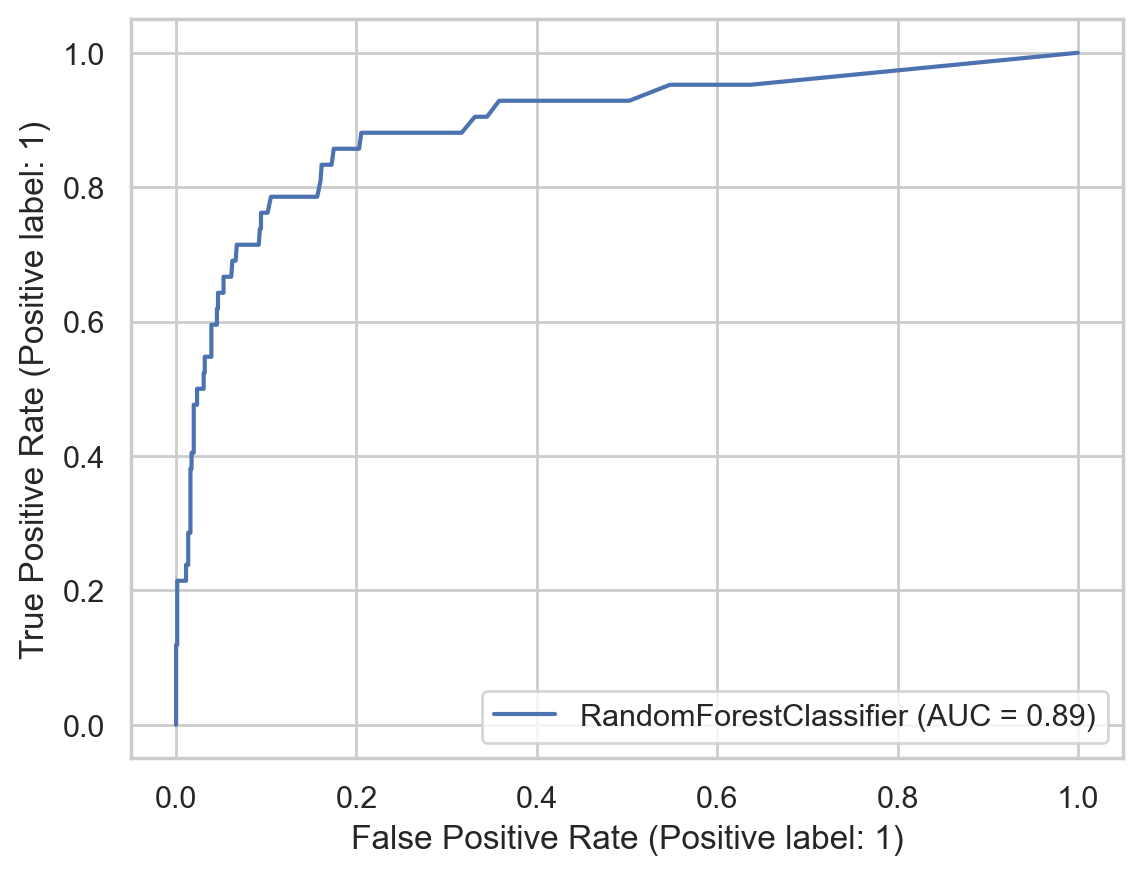

In [37]:
fig, ax = plt.subplots()
rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val, y_val, ax=ax, response_method='predict_proba')
plt.show()